In [5]:
from torch_geometric.datasets import QM9
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
import torch
from random import randint

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
dataset = QM9(root="./dataset/")

In [8]:
data = dataset.data
print(data)
print(dataset.num_features)
print(dataset.num_classes)
print(len(dataset))

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], idx=[130831], name=[130831], z=[2359210])
11
19
130831


D:\GNN\.venv\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [9]:
# dataset.print_summary()
target = 6 # Setting zero point vibrational energy as the target variable.
dataset.y = dataset.y[:, target]

In [10]:
dataset.x[0]

tensor([0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.])

In [11]:
dataset.y[0]

tensor(1.2177)

In [12]:
def plot_graph(graph_data):
    graph = to_networkx(graph_data, to_undirected=True)
    
    def visualize_graph(G):
        plt.figure(figsize=(7,7))
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True)
        plt.show()
    
    visualize_graph(graph)

torch.Size([18, 11])
torch.Size([1, 19])


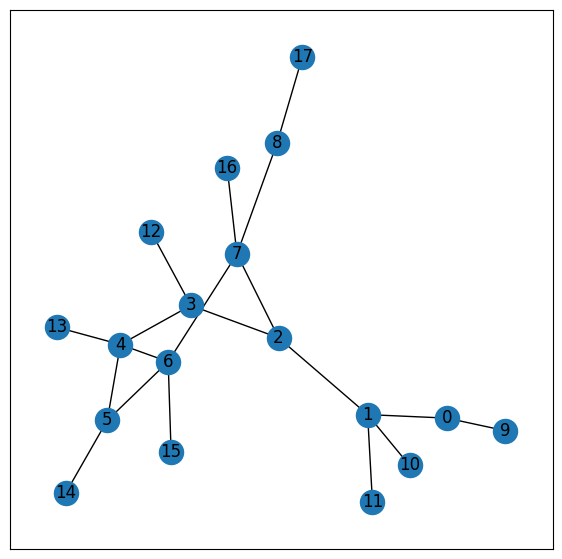

torch.Size([20, 11])
torch.Size([1, 19])


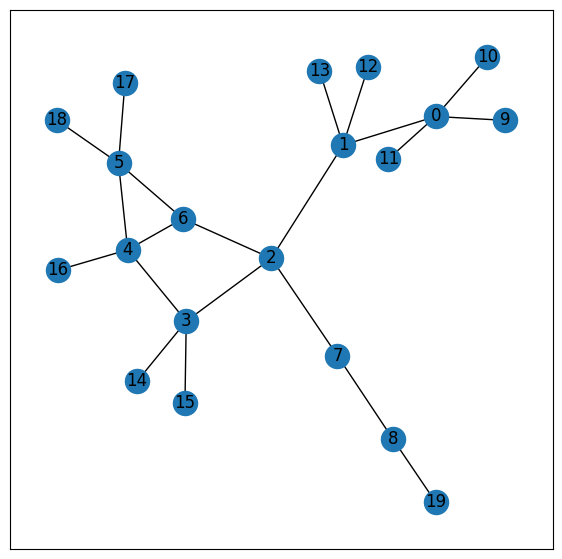

torch.Size([15, 11])
torch.Size([1, 19])


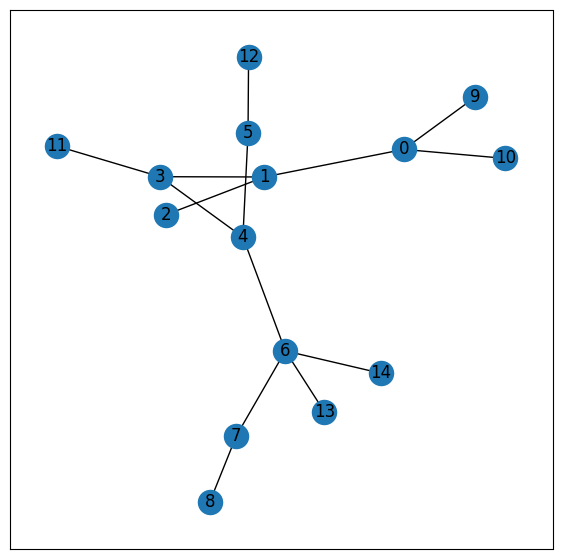

torch.Size([15, 11])
torch.Size([1, 19])


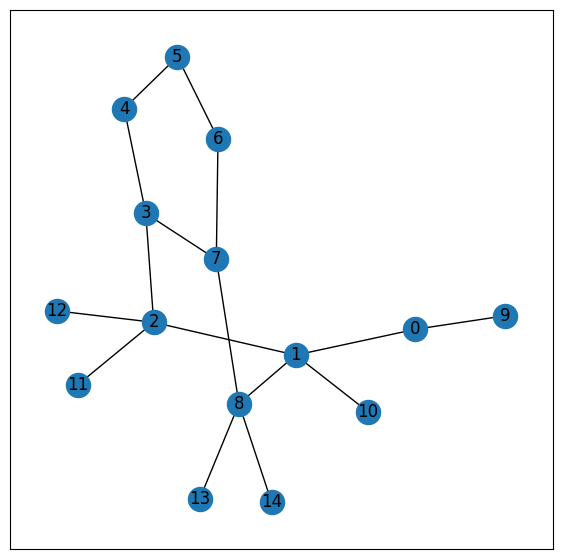

torch.Size([15, 11])
torch.Size([1, 19])


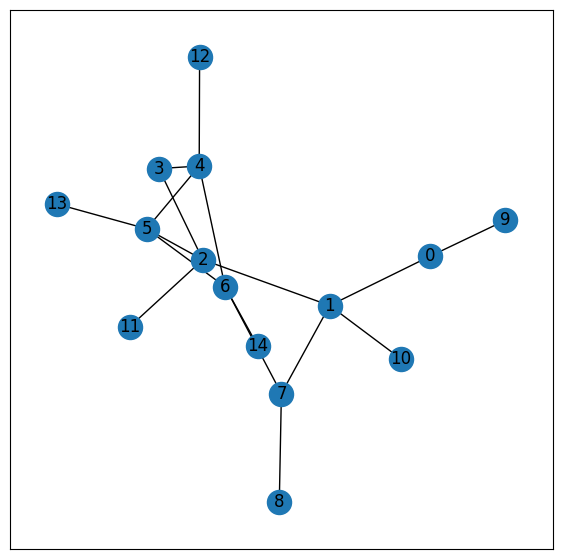

In [13]:
for _ in range(0, 5):
    idx = randint(0, len(dataset) - 1)
    data = dataset[idx]
    print(data.x.shape)
    print(data.y.shape)
    plot_graph(data)

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Input converted from 11 dims to 16 x 16 then linear function used to convert back to 1 dim.
        self.conv1 = GCNConv(in_channels, hidden_channels, normalize=False)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, normalize=False)
        self.lin = Linear(hidden_channels, out_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        
    def forward(self, data):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = global_mean_pool(x, batch_idx)
        x = self.lin(x)
        
        return x


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, normalize=False)
        self.conv2 = SAGEConv(hidden_channels, out_channels, normalize=False)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x  


In [15]:
test_dataset = dataset[:10000]
val_dataset = dataset[10000:20000]
train_dataset = dataset[20000:]
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [16]:
def train(model, optimizer, mse):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch)
        loss = mse(outputs, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

In [17]:
@torch.no_grad()
def test(model, mse):
    model.eval()
    total_loss = 0
    for batch in test_loader:
        prediction = model(batch)
        loss = mse(prediction, batch.y)
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [18]:
gcn = GCN(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)
# gat = GAT(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)
# sage = SAGEConv(in_channels=dataset.num_features, hidden_channels=16, out_channels=dataset.num_classes).to(device)

In [19]:
models = [gcn]

In [20]:
for model in models:
    # compiled = model.compile()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mse = torch.nn.MSELoss()
    for epoch in range(100):
        loss = train(model, optimizer, mse)
        print(f"Epoch: {epoch}, Loss: {loss}")
    testing_loss = test(model, mse)
    print(f"Testing Loss: {testing_loss}")

Epoch: 0, Loss: 22471064.027713627
Epoch: 1, Loss: 6012344.459728638
Epoch: 2, Loss: 315716.43055580615
Epoch: 3, Loss: 26637.010658739895
Epoch: 4, Loss: 20390.41263599704
Epoch: 5, Loss: 17940.751833591945
Epoch: 6, Loss: 16452.67942418898
Epoch: 7, Loss: 15606.854878978422
Epoch: 8, Loss: 14923.747448645894
Epoch: 9, Loss: 14154.160398135284
Epoch: 10, Loss: 13491.783819396831
Epoch: 11, Loss: 13253.278614634455
Epoch: 12, Loss: 12757.226251826825
Epoch: 13, Loss: 12610.1401006333
Epoch: 14, Loss: 12338.249822955759
Epoch: 15, Loss: 12197.190001736612
Epoch: 16, Loss: 12048.566916520822
Epoch: 17, Loss: 11927.510479158396
Epoch: 18, Loss: 11868.365481898636
Epoch: 19, Loss: 11884.690205844941
Epoch: 20, Loss: 11749.190962511728
Epoch: 21, Loss: 11740.66660877959
Epoch: 22, Loss: 11595.846421450997
Epoch: 23, Loss: 11568.186560086786
Epoch: 24, Loss: 11501.209938384094


KeyboardInterrupt: 